In [1]:
### General imports ###
import os
import random
from glob import glob
import pickle
import itertools
import numpy as np
from scipy.stats import zscore
import sys
import time
from tqdm import tqdm
### Graph imports ###
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from IPython.display import Image as Imag
### Audio import ###
import librosa
import IPython
from IPython.display import Audio

---
#
---
#
---

# **AISHELL**

---
#
---
#
---

In [64]:
import tarfile
import os

# Path to the .tgz file
tgz_path = '/kaggle/input/aishell/data_aishell.tgz'

# Extraction destination
extract_path = '/kaggle/working/data_aishell'

# Create the directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Extract the tar.gz file
with tarfile.open(tgz_path, "r:gz") as tar:
    tar.extractall(path=extract_path)

print("Extraction complete.")


Extraction complete.


In [67]:
import os
import tarfile
import shutil
import random

In [68]:
# Paths
base_path = "/kaggle/working/data_aishell/data_aishell/wav"
extracted_path = "/kaggle/working/aishell_extracted"
os.makedirs(extracted_path, exist_ok=True)
# List all .tar.gz files (users)
all_tar_files = [f for f in os.listdir(base_path) if f.endswith(".tar.gz")]
# Randomly select 40 users
random.seed(42)  # for reproducibility
selected_tar_files = random.sample(all_tar_files, 40)
selected_tar_files

['S0735.tar.gz',
 'S0106.tar.gz',
 'S0029.tar.gz',
 'S0020.tar.gz',
 'S0111.tar.gz',
 'S0916.tar.gz',
 'S0067.tar.gz',
 'S0112.tar.gz',
 'S0163.tar.gz',
 'S0170.tar.gz',
 'S0167.tar.gz',
 'S0046.tar.gz',
 'S0754.tar.gz',
 'S0165.tar.gz',
 'S0069.tar.gz',
 'S0208.tar.gz',
 'S0130.tar.gz',
 'S0133.tar.gz',
 'S0161.tar.gz',
 'S0044.tar.gz',
 'S0661.tar.gz',
 'S0154.tar.gz',
 'S0242.tar.gz',
 'S0342.tar.gz',
 'S0019.tar.gz',
 'S0095.tar.gz',
 'S0172.tar.gz',
 'S0182.tar.gz',
 'S0421.tar.gz',
 'S0059.tar.gz',
 'S0022.tar.gz',
 'S0748.tar.gz',
 'S0423.tar.gz',
 'S0217.tar.gz',
 'S0032.tar.gz',
 'S0768.tar.gz',
 'S0128.tar.gz',
 'S0715.tar.gz',
 'S0214.tar.gz',
 'S0731.tar.gz']

In [69]:
# Extract each selected user and delete the tar.gz after extraction
for file in selected_tar_files:
    tar_path = os.path.join(base_path, file)
    speaker_id = file.replace(".tar.gz", "")
    speaker_extract_path = os.path.join(extracted_path, speaker_id)
    print(f"Extracting {file}...")
    try:
        with tarfile.open(tar_path, "r:gz") as tar:
            tar.extractall(path=speaker_extract_path)
        os.remove(tar_path)  # Delete tar.gz after extraction
    except Exception as e:
        print(f"Error processing {file}: {e}")

# Remove the original base_path directory to save space
try:
    shutil.rmtree(base_path)
    print(f"\nDeleted {base_path} to save space.")
except Exception as e:
    print(f"\nCould not delete {base_path}: {e}")

Extracting S0735.tar.gz...
Extracting S0106.tar.gz...
Extracting S0029.tar.gz...
Extracting S0020.tar.gz...
Extracting S0111.tar.gz...
Extracting S0916.tar.gz...
Extracting S0067.tar.gz...
Extracting S0112.tar.gz...
Extracting S0163.tar.gz...
Extracting S0170.tar.gz...
Extracting S0167.tar.gz...
Extracting S0046.tar.gz...
Extracting S0754.tar.gz...
Extracting S0165.tar.gz...
Extracting S0069.tar.gz...
Extracting S0208.tar.gz...
Extracting S0130.tar.gz...
Extracting S0133.tar.gz...
Extracting S0161.tar.gz...
Extracting S0044.tar.gz...
Extracting S0661.tar.gz...
Extracting S0154.tar.gz...
Extracting S0242.tar.gz...
Extracting S0342.tar.gz...
Extracting S0019.tar.gz...
Extracting S0095.tar.gz...
Extracting S0172.tar.gz...
Extracting S0182.tar.gz...
Extracting S0421.tar.gz...
Extracting S0059.tar.gz...
Extracting S0022.tar.gz...
Extracting S0748.tar.gz...
Extracting S0423.tar.gz...
Extracting S0217.tar.gz...
Extracting S0032.tar.gz...
Extracting S0768.tar.gz...
Extracting S0128.tar.gz...
E

In [70]:
def mel_spectrogram(y, sr=16000, n_fft=512, win_length=256, hop_length=128, window='hamming', n_mels=64, fmax=8000):
    mel_spect = np.abs(librosa.stft(y, n_fft=n_fft, window=window, win_length=win_length, hop_length=hop_length)) ** 2
    mel_spect = librosa.feature.melspectrogram(S=mel_spect, sr=sr, n_mels=n_mels, fmax=fmax)
    mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
    return mel_spect

def frame(x, max_frames, win_size):
    win_step = (x.shape[1] - win_size) // (max_frames - 1)
    win_step = max(win_step, 1)
    frames = np.zeros((max_frames, x.shape[0], win_size)).astype(np.float32)
    start = 0
    for t in range(max_frames):
        frames[t, :, :] = x[:, start:start + win_size].astype(np.float32)
        start += win_step
    return frames

In [71]:
X_train = []
y_train = []
base_path = '/kaggle/working/aishell_extracted'
all_speakers = os.listdir(base_path)
selected_speakers = all_speakers.copy() #random.sample(all_speakers, 30)  # Random 30 speakers
len(selected_speakers)

40

In [72]:
for speaker in tqdm(selected_speakers):
    speaker_dir = os.path.join(base_path, speaker)

    # Recursively find all .wav files
    wav_files = []
    for root, _, files in os.walk(speaker_dir):
        for f in files:
            if f.endswith(".wav"):
                wav_files.append(os.path.join(root, f))
    for wav_path in wav_files:
        try:
            y, sr = librosa.load(wav_path, sr=16000)
            vad = librosa.effects.split(y, top_db=30)
            start = vad[0][0]
            end = vad[-1][1]
            y = y[start:end]

            if len(y) > 16000:
                if len(y) > 65536:
                    y = y[:65536]
                spec = mel_spectrogram(y)  # Your custom function
                X_train.append(frame(spec, 8, 64))  # Your framing function
                y_train.append(speaker)
        except Exception as e:
            print(f"Error processing {wav_path}: {e}")

100%|██████████| 40/40 [01:22<00:00,  2.06s/it]


In [73]:
labels = np.asarray(y_train).ravel()
print("Number of audio files imported: {}".format(labels.shape[0]))

Number of audio files imported: 14097


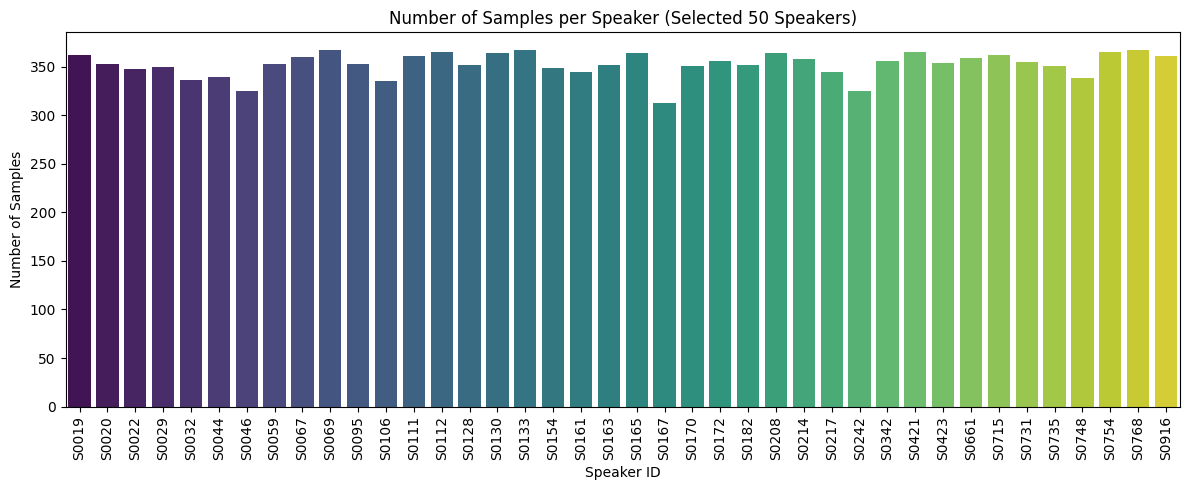

In [74]:
from collections import Counter
# Count how many samples per speaker
speaker_counts = Counter(labels)
# Convert to sorted list for plotting
speakers, counts = zip(*sorted(speaker_counts.items(), key=lambda x: x[0]))
# Plot
plt.figure(figsize=(12, 5))
sns.barplot(x=list(speakers), y=list(counts), palette="viridis")

plt.xticks(rotation=90)
plt.xlabel("Speaker ID")
plt.ylabel("Number of Samples")
plt.title("Number of Samples per Speaker (Selected 50 Speakers)")
plt.tight_layout()
plt.show()

In [75]:
from sklearn.model_selection import StratifiedKFold
from collections import defaultdict
from sklearn.preprocessing import Normalizer , scale, LabelEncoder, StandardScaler

# === Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)
X = np.array(X_train)
y = np.array(y_encoded)
# === Expand dims for CNN if needed: (samples, time, freq) -> (samples, time, freq, 1)
X = X[..., np.newaxis]
# === Cross-validation setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [76]:
from sklearn.model_selection import StratifiedKFold
import pickle

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds = list(skf.split(X, y))

# Save folds to disk
with open("/kaggle/working/aishell_folds.pkl", "wb") as f:
    pickle.dump(folds, f)

In [ ]:
with open("/kaggle/input/vctk_ind/fold_indices.pkl", "rb") as f:
    folds = pickle.load(f)

# Use same splits
for fold_idx, (train_idx, val_idx) in enumerate(folds):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

In [77]:
# Check class distribution in each fold
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    y_val = y[val_idx]
    class_counts = Counter(y_val)
    print(f"Fold {fold_idx + 1} class distribution:")
    for class_id, count in sorted(class_counts.items()):
        label = label_encoder.inverse_transform([class_id])[0]
        print(f"  Class {label} ({class_id}): {count} samples")
    print("-" * 40)

Fold 1 class distribution:
  Class S0019 (0): 72 samples
  Class S0020 (1): 71 samples
  Class S0022 (2): 69 samples
  Class S0029 (3): 70 samples
  Class S0032 (4): 67 samples
  Class S0044 (5): 68 samples
  Class S0046 (6): 65 samples
  Class S0059 (7): 71 samples
  Class S0067 (8): 72 samples
  Class S0069 (9): 73 samples
  Class S0095 (10): 71 samples
  Class S0106 (11): 67 samples
  Class S0111 (12): 72 samples
  Class S0112 (13): 73 samples
  Class S0128 (14): 71 samples
  Class S0130 (15): 73 samples
  Class S0133 (16): 73 samples
  Class S0154 (17): 70 samples
  Class S0161 (18): 69 samples
  Class S0163 (19): 70 samples
  Class S0165 (20): 73 samples
  Class S0167 (21): 63 samples
  Class S0170 (22): 70 samples
  Class S0172 (23): 71 samples
  Class S0182 (24): 71 samples
  Class S0208 (25): 73 samples
  Class S0214 (26): 72 samples
  Class S0217 (27): 69 samples
  Class S0242 (28): 65 samples
  Class S0342 (29): 71 samples
  Class S0421 (30): 73 samples
  Class S0423 (31): 71

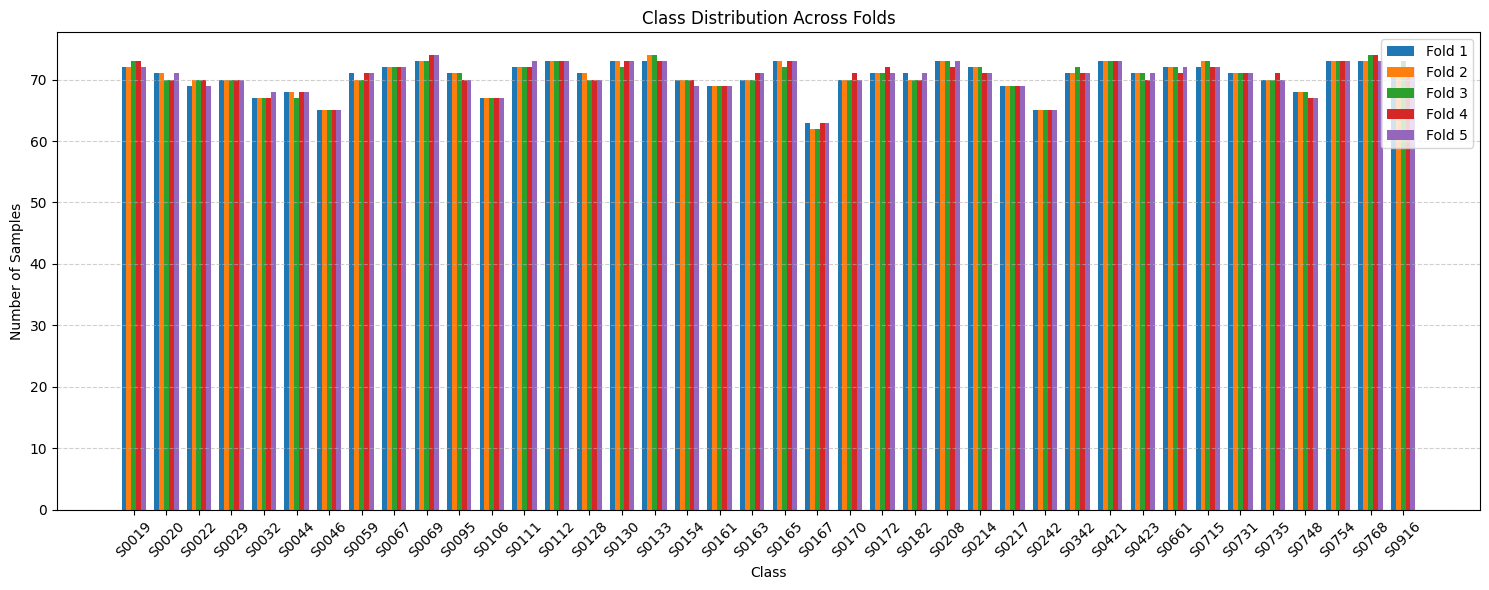

In [78]:
# === Setup for plotting
num_folds = 5
fold_distributions = []
class_labels = label_encoder.classes_

for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    y_val = y[val_idx]
    class_counts = Counter(y_val)
    counts = [class_counts.get(cls_id, 0) for cls_id in range(len(class_labels))]
    fold_distributions.append(counts)

# === Convert to NumPy array for easy plotting
fold_distributions = np.array(fold_distributions)  # shape: (num_folds, num_classes)
x = np.arange(len(class_labels))  # Class indices

# === Plotting
plt.figure(figsize=(15, 6))
bar_width = 0.15

for i in range(num_folds):
    plt.bar(x + i * bar_width, fold_distributions[i], width=bar_width, label=f'Fold {i+1}')

plt.xticks(x + bar_width * (num_folds - 1) / 2, class_labels, rotation=45)
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.title("Class Distribution Across Folds")
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# TRAINING

In [79]:
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv3D, MaxPooling3D, TimeDistributed, Conv2D,
                                     Activation, MaxPooling2D, Flatten, LSTM, Dense,
                                     Dropout, BatchNormalization)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD

### Time Distributed ConvNet imports ###
import tensorflow as tf
import keras
from tensorflow.keras import backend as K
from keras.regularizers import L2
from keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, TimeDistributed, concatenate, LSTM, Flatten, BatchNormalization, LeakyReLU, Reshape
from tensorflow.keras.layers import Conv3D, MaxPool3D, ConvLSTM3D, MaxPooling3D, AveragePooling3D, ZeroPadding3D, Convolution3D
from tensorflow.keras.layers import Conv2D, MaxPool2D, ConvLSTM2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Convolution2D
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Adamax, Nadam
from tensorflow.keras.models import Sequential, Model, load_model,  model_from_json
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
### Warning ###
import warnings
warnings.filterwarnings('ignore')

2.18.0


In [80]:
def create_cnn_model(input_shape, num_classes):
    weight_decay = 1e-4
    model = Sequential()
    # Conv3D Block 1
    model.add(Conv3D(16, kernel_size=(3, 3, 3), activation='relu', padding='same',kernel_regularizer=l2(weight_decay), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv3D(16, kernel_size=(3, 3, 3), activation='relu', padding='same',kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
    model.add(Dropout(0.2))
    # TimeDistributed Conv2D Block 1
    model.add(TimeDistributed(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same',kernel_regularizer=l2(weight_decay))))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Activation('elu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides=(3, 3), padding='same')))
    model.add(Dropout(0.2))
    # Conv3D Block 2
    model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same',kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same',kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
    model.add(Dropout(0.2))
    # TimeDistributed Conv2D Block 2
    model.add(TimeDistributed(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same',kernel_regularizer=l2(weight_decay))))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Activation('elu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides=(3, 3), padding='same')))
    model.add(Dropout(0.2))
    # LSTM + Output
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(256, return_sequences=False, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(num_classes, activation='softmax',kernel_regularizer=l2(weight_decay)))
    model.compile(loss='sparse_categorical_crossentropy',optimizer=SGD(learning_rate=0.01, momentum=0.9),metrics=['accuracy'])
    return model

In [81]:
from tensorflow.keras import mixed_precision
import sys

mixed_precision.set_global_policy('mixed_float16')

for name, size in sorted(((name, sys.getsizeof(val)) for name, val in globals().items()), 
                         key=lambda x: -x[1])[:10]:  # top 10
    print(f"{name}: {size / (1024 ** 2):.2f} MB")

X_val: 294.13 MB
feat_train: 4.60 MB
feat_val: 1.15 MB
y_pred_probs: 0.13 MB
X_train: 0.12 MB
y_train: 0.12 MB
y: 0.11 MB
y_encoded: 0.11 MB
train_idx: 0.09 MB
spec: 0.07 MB


In [ ]:
# Delete large variables
del model, history, results, feat_train, feat_val

# Clear cache
import gc
gc.collect()

In [82]:
fold_accuracies = []
# === Loop through folds
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\n=== Fold {fold_idx+1} ===")
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    # Create a new model
    model = create_cnn_model(input_shape=X.shape[1:], num_classes=len(label_encoder.classes_))
    # Define checkpoint path
    checkpoint_path = f'/kaggle/working/aishell_models/model_fold_{fold_idx+1}.keras'
    # Setup model checkpoint
    model_check = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,monitor='val_accuracy',
                                                     mode='max',save_best_only=True,verbose=0)
    # Train model
    history = model.fit(X_train, y_train,validation_data=(X_val, y_val),epochs=100,batch_size=32,callbacks=[model_check],verbose=0)
    time.sleep(2)
    # Load the best saved model
    best_model = tf.keras.models.load_model(checkpoint_path)
    # Evaluate the best model
    val_acc = best_model.evaluate(X_val, y_val, verbose=0)[1]
    fold_accuracies.append(val_acc)
    print(f"Best Model Validation Accuracy: {val_acc:.4f}")


=== Fold 1 ===
Best Model Validation Accuracy: 0.9993

=== Fold 2 ===
Best Model Validation Accuracy: 0.9993

=== Fold 3 ===
Best Model Validation Accuracy: 1.0000

=== Fold 4 ===
Best Model Validation Accuracy: 0.9982

=== Fold 5 ===
Best Model Validation Accuracy: 0.9993


In [84]:
# === Summary
mean_acc = np.mean(fold_accuracies)
std_acc = np.std(fold_accuracies)
print(f"\n✅ 5-Fold Results: Accuracies = {fold_accuracies}")
print(f"Mean Accuracy = {mean_acc:.5f}, Std = {std_acc:.5f}")


✅ 5-Fold Results: Accuracies = [0.9992907643318176, 0.9992907643318176, 1.0, 0.9982263445854187, 0.9992905259132385]
Mean Accuracy = 0.99922, Std = 0.00057


In [106]:
std = np.std([0.9992907643318176, 0.9992907643318176, 1.0, 0.9982263445854187, 0.9992905259132385], ddof=1)
std

0.0006345745929644084

In [85]:
import scipy.stats as stats
# Basic statistics
mean_acc = np.mean(fold_accuracies)
std_dev = np.std(fold_accuracies, ddof=1)  # ddof=1 for sample standard deviation
n = len(fold_accuracies)

# 95% confidence interval using t-distribution
confidence = 0.95
alpha = 1 - confidence
t_crit = stats.t.ppf(1 - alpha/2, df=n-1)
margin_error = t_crit * (std_dev / np.sqrt(n))
ci_lower = mean_acc - margin_error
ci_upper = mean_acc + margin_error

# One-sample t-test against baseline (e.g., 0.95)
baseline = 0.95
t_stat, p_val = stats.ttest_1samp(fold_accuracies, baseline)

# One-sided p-value (greater than baseline)
p_val_one_sided = p_val / 2 if t_stat > 0 else 1 - p_val / 2

# Print results
print(f"Mean Accuracy: {mean_acc:.5f}")
print(f"Standard Deviation: {std_dev:.5f}")
print(f"95% Confidence Interval: [{ci_lower:.5f}, {ci_upper:.5f}]")
print(f"p-value: {p_val:.4f}")
print(f"t-statistic vs baseline {baseline}: {t_stat:.3f}")
print(f"One-sided p-value: {p_val_one_sided:.10f}")

# Interpretation
if p_val_one_sided < 0.05:
    print("Result: Statistically significant improvement over baseline (p < 0.05).")
else:
    print("Result: Not statistically significant at the 0.05 level.")

Mean Accuracy: 0.99922
Standard Deviation: 0.00063
95% Confidence Interval: [0.99843, 1.00001]
p-value: 0.0000
t-statistic vs baseline 0.95: 173.437
One-sided p-value: 0.0000000033
Result: Statistically significant improvement over baseline (p < 0.05).


In [88]:
fold_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1s = []

for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\n=== Evaluating Fold {fold_idx+1} ===")
    X_val = X[val_idx]
    y_val = y[val_idx]

    # Load the saved model
    model = tf.keras.models.load_model(f'/kaggle/working/aishell_models/model_fold_{fold_idx+1}.keras')
    
    # Predict class probabilities and then convert to class labels
    y_pred_probs = model.predict(X_val, verbose=0)
    y_pred = y_pred_probs.argmax(axis=1)

    # Compute metrics
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_val, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_val, y_pred, average='macro', zero_division=0)

    fold_accuracies.append(acc)
    fold_precisions.append(prec)
    fold_recalls.append(rec)
    fold_f1s.append(f1)
    print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")

# Summary
print("\n=== Summary of Evaluation Metrics ===")
for i in range(len(fold_accuracies)):
    print(f"Fold {i+1}: Acc={fold_accuracies[i]:.4f}, Prec={fold_precisions[i]:.4f}, Rec={fold_recalls[i]:.4f}, F1={fold_f1s[i]:.4f}")
print(f"\nMean Accuracy:  {np.mean(fold_accuracies):.4f}")
print(f"Mean Precision: {np.mean(fold_precisions):.4f}")
print(f"Mean Recall:    {np.mean(fold_recalls):.4f}")
print(f"Mean F1 Score:  {np.mean(fold_f1s):.4f}")


=== Evaluating Fold 1 ===
Accuracy: 0.9993 | Precision: 0.9993 | Recall: 0.9993 | F1: 0.9993

=== Evaluating Fold 2 ===
Accuracy: 0.9993 | Precision: 0.9993 | Recall: 0.9993 | F1: 0.9993

=== Evaluating Fold 3 ===
Accuracy: 1.0000 | Precision: 1.0000 | Recall: 1.0000 | F1: 1.0000

=== Evaluating Fold 4 ===
Accuracy: 0.9982 | Precision: 0.9983 | Recall: 0.9983 | F1: 0.9983

=== Evaluating Fold 5 ===
Accuracy: 0.9993 | Precision: 0.9993 | Recall: 0.9993 | F1: 0.9993

=== Summary of Evaluation Metrics ===
Fold 1: Acc=0.9993, Prec=0.9993, Rec=0.9993, F1=0.9993
Fold 2: Acc=0.9993, Prec=0.9993, Rec=0.9993, F1=0.9993
Fold 3: Acc=1.0000, Prec=1.0000, Rec=1.0000, F1=1.0000
Fold 4: Acc=0.9982, Prec=0.9983, Rec=0.9983, F1=0.9983
Fold 5: Acc=0.9993, Prec=0.9993, Rec=0.9993, F1=0.9993

Mean Accuracy:  0.9992
Mean Precision: 0.9992
Mean Recall:    0.9992
Mean F1 Score:  0.9992


In [89]:
# Basic statistics
mean_acc = np.mean(fold_accuracies)
std_dev = np.std(fold_accuracies, ddof=1)  # ddof=1 for sample standard deviation
n = len(fold_accuracies)

# 95% confidence interval using t-distribution
confidence = 0.95
alpha = 1 - confidence
t_crit = stats.t.ppf(1 - alpha/2, df=n-1)
margin_error = t_crit * (std_dev / np.sqrt(n))
ci_lower = mean_acc - margin_error
ci_upper = mean_acc + margin_error

# One-sample t-test against baseline (e.g., 0.95)
baseline = 0.95
t_stat, p_val = stats.ttest_1samp(fold_accuracies, baseline)

# One-sided p-value (greater than baseline)
p_val_one_sided = p_val / 2 if t_stat > 0 else 1 - p_val / 2

# Print results
print(f"Mean Accuracy: {mean_acc:.5f}")
print(f"Standard Deviation: {std_dev:.5f}")
print(f"95% Confidence Interval: [{ci_lower:.5f}, {ci_upper:.5f}]")
print(f"p-value: {p_val:.4f}")
print(f"t-statistic vs baseline {baseline}: {t_stat:.3f}")
print(f"One-sided p-value: {p_val_one_sided:.4f}")

# Interpretation
if p_val_one_sided < 0.05:
    print("Result: Statistically significant improvement over baseline (p < 0.05).")
else:
    print("Result: Not statistically significant at the 0.05 level.")

Mean Accuracy: 0.99922
Standard Deviation: 0.00063
95% Confidence Interval: [0.99843, 1.00001]
p-value: 0.0000
t-statistic vs baseline 0.95: 173.434
One-sided p-value: 0.0000
Result: Statistically significant improvement over baseline (p < 0.05).


# CLASSIFIERS

In [90]:
# Machine learning
import xgboost as xgb
from sklearn import svm
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, log_loss, hinge_loss
from sklearn.preprocessing import Normalizer , scale, LabelEncoder, StandardScaler

In [91]:
def embeds_model(input_shape):
    weight_decay = 1e-4
    model = Sequential()
    model.add(Conv3D(16, kernel_size=(3, 3, 3), activation='relu', padding='same',kernel_regularizer=l2(weight_decay), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv3D(16, kernel_size=(3, 3, 3), activation='relu', padding='same',kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
    model.add(Dropout(0.2))
    model.add(TimeDistributed(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same',kernel_regularizer=l2(weight_decay))))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Activation('elu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides=(3, 3), padding='same')))
    model.add(Dropout(0.2))
    model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same',kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same',kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
    model.add(Dropout(0.2))
    model.add(TimeDistributed(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same',kernel_regularizer=l2(weight_decay))))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Activation('elu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides=(3, 3), padding='same')))
    model.add(Dropout(0.2))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(256, return_sequences=False, dropout=0.2, recurrent_dropout=0.2))
    return model

In [92]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Classifier definitions
classifiers = {
    'SVM (Linear)': SVC(kernel='linear'),
    'SVM (RBF)': SVC(kernel='rbf'),
    'SVM (Poly)': SVC(kernel='poly'),
    'SVM (Sigmoid)': SVC(kernel='sigmoid'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)}

In [93]:
# Store results
results = defaultdict(list)
# === Cross-validation loop
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\n=== Fold {fold_idx + 1} ===")    
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    # === Load pretrained model and extract features
    new_model = embeds_model(input_shape=X_train.shape[1:])
    pretrained_model =  load_model(f'/kaggle/working/aishell_models/model_fold_{fold_idx+1}.keras')
    for i, layer in enumerate(pretrained_model.layers[:-1]): 
        new_model.layers[i].set_weights(layer.get_weights())
    for layer in new_model.layers:
        layer.trainable = False
    model.compile(loss='sparse_categorical_crossentropy',optimizer=SGD(learning_rate=0.01, momentum=0.9),metrics=['accuracy'])
    feat_train = new_model.predict(X_train, verbose=0)
    feat_val = new_model.predict(X_val, verbose=0)
    # === Loop over classifiers
    for clf_name, clf in classifiers.items():
        clf.fit(feat_train, y_train)
        y_pred = clf.predict(feat_val)
        acc = accuracy_score(y_val, y_pred)
        prec = precision_score(y_val, y_pred, average='macro')
        rec = recall_score(y_val, y_pred, average='macro')
        f1 = f1_score(y_val, y_pred, average='macro')
        results[clf_name].append({
            'fold': fold_idx + 1,
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1})
        print(f"{clf_name} — Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}")
    print('---------------------------------------------------------')


=== Fold 1 ===
SVM (Linear) — Accuracy: 0.9989, Precision: 0.9989, Recall: 0.9990, F1 Score: 0.9989
SVM (RBF) — Accuracy: 0.9989, Precision: 0.9990, Recall: 0.9990, F1 Score: 0.9990
SVM (Poly) — Accuracy: 0.9993, Precision: 0.9993, Recall: 0.9993, F1 Score: 0.9993
SVM (Sigmoid) — Accuracy: 0.9989, Precision: 0.9989, Recall: 0.9990, F1 Score: 0.9989
Random Forest — Accuracy: 0.9982, Precision: 0.9983, Recall: 0.9983, F1 Score: 0.9983
XGBoost — Accuracy: 0.9940, Precision: 0.9940, Recall: 0.9940, F1 Score: 0.9940
---------------------------------------------------------

=== Fold 2 ===
SVM (Linear) — Accuracy: 0.9993, Precision: 0.9993, Recall: 0.9993, F1 Score: 0.9993
SVM (RBF) — Accuracy: 0.9993, Precision: 0.9993, Recall: 0.9993, F1 Score: 0.9993
SVM (Poly) — Accuracy: 0.9989, Precision: 0.9990, Recall: 0.9989, F1 Score: 0.9989
SVM (Sigmoid) — Accuracy: 0.9993, Precision: 0.9993, Recall: 0.9993, F1 Score: 0.9993
Random Forest — Accuracy: 0.9986, Precision: 0.9986, Recall: 0.9986, F1 